In [4]:
import pandas as pd

**Implementation**

In [255]:
from data_collection import download_dataset, read_dataset
from data_processing import add_stats
from typing import List
from abc import ABC, abstractproperty


def get_data(from_symbol='LTC', datetime_interval='minute', exchange='Coinbase'):
    """
    Get Historical dataframe
    """
    to_symbol = 'USD'

    df, filename = download_dataset(
        from_symbol, to_symbol, exchange, datetime_interval
    )

    df = read_dataset(filename)
    df = add_stats(df)
    return df


class Bookie(ABC):

    def __init__(self, funds):
        self.pct_fee = 0.0
        self.funds = funds
        self.num_coins_held = 0
        self.in_position = False
        self.df = None
        self.funds_records = []
        self.bought_stamps = []
        self.sold_stamps = []
        
    def __get_price(self):
        price = self.df['close'][-1]
        return price

    def __get_num_coins_affordable(self):
        coin_price = self.__get_price()
        num_coins = self.funds / coin_price
        return num_coins
    
    def __get_holding_value(self):
        return self.__get_price() * self.num_coins_held

    def market_buy(self) -> bool:
        """[execute a market buy]
        NOTE: Makes the naive assumption that you will 
        be filled at the last interval close.
        """
        self.funds -= self.funds * self.pct_fee
        self.num_coins_held = self.__get_num_coins_affordable()
        self.funds = 0
        self.in_position = True
        self.bought_stamps.append(str(self.df.index[-1]))
        return True

    def market_sell(self) -> float:
        """[execute a market sell]
        NOTE: Makes the naive assumption that you will 
        be filled at the last interval close.
        """
        self.funds = self.__get_holding_value()
        self.funds -= self.funds * self.pct_fee
        self.num_coins_held = 0
        self.in_position = False
        self.sold_stamps.append(str(self.df.index[-1]))
        return self.funds
    
    def maybe_exit_pos(self, profit_pct_cutoff=0.05, loss_pct_cutoff=-0.05):
        """
        When called, will take profit or losses, if applicable.
        """
        last_funds = self.funds_records[-1]
        holding_value = self.__get_holding_value()
        diff = holding_value - last_funds
        percent = diff / last_funds
        if self.in_position:
            if percent <= loss_pct_cutoff \
            or percent >= profit_pct_cutoff:
                self.market_sell()
                
        

class BorutoBotto(Bookie):

    def __init__(self, funds=1000):
        super().__init__(funds)

        accepted_symbols = ['BTC', 'LTC', 'XLM', 'ETH', 'ECT', '...']
        self.funds_records.append(funds)
        self.df

    def __is_bullish(self):
        pass

    def __is_bearish(self):
        pass

    def __rsi_below_x(self, x):
        rsik = self.df['rsi'][-1]
        return rsik < x

    def __rsi_above_x(self, x):
        rsik = self.df['rsi'][-1]
        return rsik > x

    def __stoch_rsi_below_x(self, x):
        stoch_rsik = self.df['stoch_rsik'][-1]
        return stoch_rsik < x

    def __stoch_rsi_above_x(self, x):
        stoch_rsik = self.df['stoch_rsik'][-1]
        return stoch_rsik > x
    
    def __stoch_rsi_uptrend(self):
        stoch_rsik = self.df['stoch_rsik'][-1]
        stoch_rsik_prev = self.df['stoch_rsik'][-2]
        return stoch_rsik > stoch_rsik_prev

    def __macd_below_x(self, x):
        macd = self.df['macd'][-1]
        return macd < x

    def __macd_above_x(self, x):
        macd = self.df['macd'][-1]
        return macd > x

    def __buy_criteria_fulfilled(self):
        if self.__rsi_below_x(42) \
                and self.__stoch_rsi_below_x(15) \
                and self.__stoch_rsi_uptrend() \
                and self.__macd_below_x(-0.26):
            return True

    def __sell_criteria_fulfilled(self):
        if self.__rsi_above_x(40) \
                and self.__stoch_rsi_above_x(85):
            # and self.__macd_above_x(0.7):
            return True

    def determine_action(self, df):
        self.df = df
        if self.__buy_criteria_fulfilled() and not self.in_position:
            self.market_buy()
        elif self.__sell_criteria_fulfilled() and self.in_position:
            funds = self.market_sell()
            self.funds_records.append(funds)
        self.maybe_exit_pos()


**Grab Data**

In [256]:
from datetime import datetime
coin = 'LTC'
interval = 'minute'
df = get_data(coin, interval)

day = str(datetime.today()).split(' ')[0]
display(df.head())

Filtering 0 empty datapoints
Saving data to LTC_USD_Coinbase_minute_2021-05-15.csv
Reading data from LTC_USD_Coinbase_minute_2021-05-15.csv
(2001, 6)


,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,stoch_rsik,stoch_rsid,rsv_14,rsv,kdjk_14,kdjk
datetime,,,,,,,,,,,,,,,,,,,,
2021-05-14 13:35:00,329.59,331.50,329.81,331.37,481.04,158933.78,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.193717,93.193717,64.397906,64.397906
2021-05-14 13:36:00,331.04,332.28,331.37,332.23,769.58,255310.27,0.019295,0.010719,0.008575,331.37,0.86,inf,100.000000,100.000000,NaN,NaN,98.141264,98.141264,75.645692,75.645692
2021-05-14 13:37:00,331.54,332.50,332.23,331.54,427.28,141948.68,0.003189,0.007633,-0.004444,332.23,-0.69,1.157350,53.646833,53.646833,NaN,NaN,67.010309,67.010309,72.767231,72.767231
2021-05-14 13:38:00,330.25,331.85,331.54,330.58,722.44,239071.53,-0.038875,-0.008122,-0.030754,331.54,-0.96,0.463250,31.658970,31.658970,NaN,NaN,34.020619,34.020619,59.851694,59.851694
2021-05-14 13:39:00,329.50,330.58,330.58,329.88,322.20,106290.72,-0.088769,-0.032112,-0.056656,330.58,-0.70,0.314934,23.950543,23.950543,NaN,NaN,12.666667,12.666667,44.123351,44.123351


**Run Simulation**

starting funds: 1000, ending funds: 1006.2206689400798


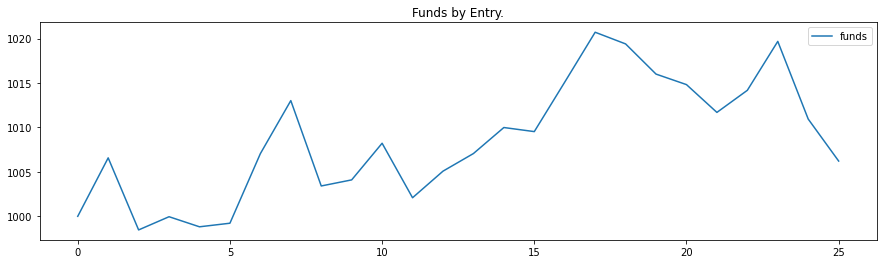

In [257]:
starting_funds = 1000
botto = BorutoBotto(starting_funds)

# loop through last 1900 rows of df, feeding them to boruto
for i in range(100,len(df)):
    botto.determine_action(df.iloc[:i])
    
ending_funds = botto.funds_records[-1]
print(f"starting funds: {starting_funds}, ending funds: {ending_funds}")

funds_data = pd.DataFrame(
    data={
        'funds': botto.funds_records,
        'index': list(range(len(botto.funds_records)))
    }
)

funds_data[["funds"]].plot(figsize=(15,4), title='Funds by Entry.')

**Transaction History**

In [254]:
df[df.index == '2021-05-14 16:52:00']

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,close_-1_s,close_-1_d,rs_14,rsi_14,rsi,stoch_rsik,stoch_rsid,rsv_14,rsv,kdjk_14,kdjk
datetime,,,,,,,,,,,,,,,,,,,,
2021-05-14 16:52:00,332.15,332.91,332.29,332.61,290.86,96763.73,-0.471076,-0.858899,0.387823,332.29,0.32,1.236815,55.293581,55.293581,100.0,100.0,91.525424,91.525424,72.769169,72.769169


In [250]:
trans_df = pd.DataFrame(data={
    'buy_stamps':botto.bought_stamps, 
    'sell_stamps':botto.sold_stamps,
    'funds':botto.funds_records[1:]}
)
trans_df['pct_change'] = trans_df['funds'].pct_change()*100
trans_df

,buy_stamps,sell_stamps,funds,pct_change
0,2021-05-14 09:59:00,2021-05-14 10:07:00,1001.044451,NaN
1,2021-05-14 10:24:00,2021-05-14 10:35:00,1003.113298,0.206669
2,2021-05-14 11:35:00,2021-05-14 11:43:00,1009.670996,0.653735
3,2021-05-14 12:04:00,2021-05-14 12:28:00,1006.898360,-0.274608
4,2021-05-14 13:24:00,2021-05-14 13:28:00,1013.372495,0.642978
5,2021-05-14 14:19:00,2021-05-14 14:28:00,1016.791264,0.337366
6,2021-05-14 15:48:00,2021-05-14 15:56:00,1023.480080,0.657836
7,2021-05-14 16:25:00,2021-05-14 16:49:00,1015.235354,-0.805558
8,2021-05-14 17:59:00,2021-05-14 18:06:00,1016.745754,0.148773
9,2021-05-14 19:14:00,2021-05-14 19:33:00,1015.592203,-0.113455
